In [122]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook



%load_ext autoreload
%autoreload 2

import Tree
np.random.seed(1)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


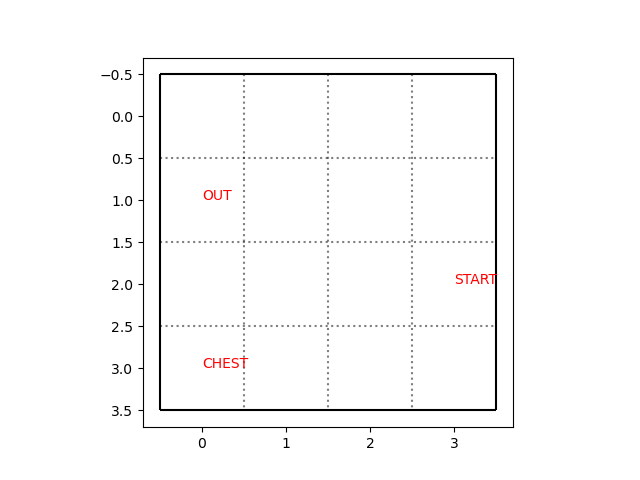

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [123]:
N_grid = 4
tree = Tree.Cell_Tree( N_grid )
tree.visu()


In [124]:
tree.build_WALL(7)
tree.build_WALL(22)
tree.build_WALL(10)
tree.build_WALL(4)
tree.build_WALL(9)
tree.build_WALL(5)
tree.build_WALL(17)
tree.build_WALL(2)
tree.build_WALL(1)
tree.build_WALL(13)








<IPython.core.display.Javascript object>


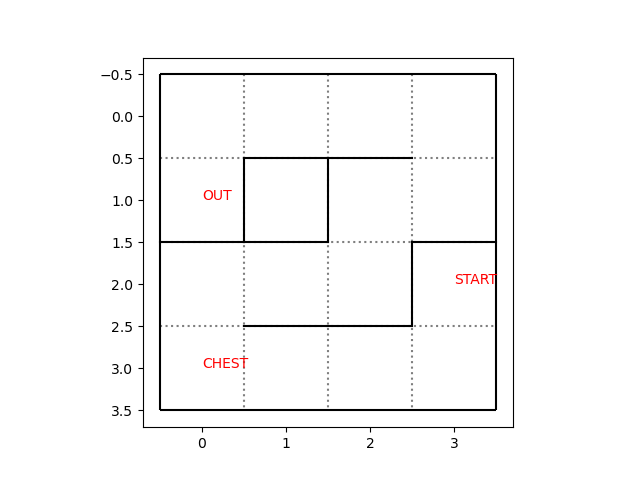

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [125]:
tree.visu()

In [126]:
tree.check( verbose = True )

Count :  1
Cell already check :  []
15
Count :  2
Cell already check :  [15]
14
Count :  3
Cell already check :  [14 15]
13
Count :  4
Cell already check :  [13 14 15]
12
Count :  5
Cell already check :  [12 13 14 15]
8
Count :  6
Cell already check :  [ 8 12 13 14 15]
9
Count :  7
Cell already check :  [ 8  9 12 13 14 15]
10
Count :  8
Cell already check :  [ 8  9 10 12 13 14 15]
6
Count :  9
Cell already check :  [ 6  8  9 10 12 13 14 15]
7
Count :  10
Cell already check :  [ 6  7  8  9 10 12 13 14 15]
3
Count :  11
Cell already check :  [ 3  6  7  8  9 10 12 13 14 15]
2
Count :  12
Cell already check :  [ 2  3  6  7  8  9 10 12 13 14 15]
1
Count :  13
Cell already check :  [ 1  2  3  6  7  8  9 10 12 13 14 15]
0
Count :  14
Cell already check :  [ 0  1  2  3  6  7  8  9 10 12 13 14 15]
4


True

In [111]:
tree.layers[3][3].previous[0].ID

9

In [ ]:
fig, ax = plt.subplots()

plt.plot( np.arange(10000), np.exp( -0.0001* np.arange(10000) ) )

In [ ]:
class Agent():
    def __init__(self, tree):  ### tree en input ?
        
        self.tree = tree ### the grid structure
    
        ### init Q-table
        self.N_state = self.tree.N_Wall+1 
        self.N_action = self.tree.N_Wall * 2
        self.Q_table = np.zeros(( self.N_state, self.N_action ))
        
        ### hyper params
        self.N_max_action = self.N_action*4
        ### Exploration
        self.exploration_proba = 1 ### init of the proba
        self.exploration_decreasing_decay = 0.0001  ### decreasing decay for exponential decreasing
        self.min_exploration_proba = 0.01 ### Minimum of exploration proba

        if 1: self.N_episodes = 10000
        else : self.N_episodes = np.ceil( np.log( self.min_exploration_proba ) / -self.exploration_decreasing_decay ).astype(int)
        #print( 'N_episodes ',N_episodes )

        self.discount = 0.8 ### Discounted factor
        self.lr = 0.3 ### learning rate

        ### Metrics
        self.total_rewards_episode = np.zeros( self.N_episodes )
          
    def train(self):
        ### we iterate over episodes
        for e in range(self.N_episodes): 

            if not(e%100):
                print( e,'/', self.N_episodes )

            ### we initialize the first state of the episode
            current_state = 0 ### START state OUT ACCESSIBLE
            self.tree.reset_tree()
            #done = False

            #sum the rewards that the agent gets from the environment
            total_episode_reward = 0

            for i in range(self.N_max_action): 
                ### we sample a float from a uniform distribution over 0 and 1
                # if the sampled float is less than the exploration proba
                #     the agent selects arandom action
                # else
                #     he exploits his knowledge using the bellman equation 

                if np.random.uniform(0,1) < self.exploration_proba:

                    action = self.__sample_action()
                else:
                    action = np.argmax(self.Q_table[current_state,:])

                # The environment runs the chosen action and returns
                # the next state, a reward and true if the epiosed is ended.
                next_state, reward, done = self.__step( action, current_state)

                # We update our Q-table using the Q-learning iteration
                self.Q_table[current_state, action] = (1-self.lr)*self.Q_table[current_state, action] + self.lr*(reward + self.discount*max(self.Q_table[next_state,:]))

                if( np.max( np.abs( self.Q_table ) ) >0 ):
                    self.Q_table =  self.Q_table / np.max( np.abs( self.Q_table ) )
                
                total_episode_reward = total_episode_reward + reward
                # If the episode is finished, we leave the for loop
                if done:
                    print( 'HERE WE BREAK' )
                    break
                current_state = next_state
            #We update the exploration proba using exponential decay formula 
            self.exploration_proba = max(self.min_exploration_proba, np.exp(-self.exploration_decreasing_decay*e))
            self.total_rewards_episode[e] = total_episode_reward
            
    def generate(self):
        
        ### we initialize the first state of the episode
        current_state = 0 ### START state OUT ACCESSIBLE
        self.tree.reset_tree()

        #sum the rewards that the agent gets from the environment
        total_episode_reward = 0

        for i in range(self.N_max_action): 

            action = np.argmax(self.Q_table[current_state,:])

            # The environment runs the chosen action and returns
            # the next state, a reward and true if the epiosed is ended.
            next_state, reward, done = self.__step( action, current_state)

            total_episode_reward = total_episode_reward + reward
            # If the episode is finished, we leave the for loop

            current_state = next_state
            
    def __sample_action( self ):
        return np.random.randint( self.N_action )
    
    def __step( self, action, current_state ):
    
        maze_state_before_action = self.tree.check() ### store before action state to compare with the post action one
        is_action_done = self.__do_action( action )  ### perform the action on the maze
        new_state = self.__get_state()
        reward = self.__get_reward( is_action_done, current_state, maze_state_before_action )

        done = False
        #if new_state == 2:
        #    done =True

        return new_state, reward, done
    
    def __do_action( self, Wall_ID ):
        ### build or brake the wall
        ### return True if the action has been done

        if Wall_ID < self.tree.N_Wall: ### CONSTRUCTION
            if self.tree.Wall_state[Wall_ID] :
                return False ###Wall already built
            else :
                self.tree.build_WALL( Wall_ID )
                return True
        else: ###DESTRUCTION
            Wall_ID_tmp = Wall_ID-self.tree.N_Wall ### 'real' Wall ID
            if self.tree.Wall_state[Wall_ID_tmp] :
                self.tree.brake_WALL( Wall_ID_tmp )
                return True 
            else :
                return False ### Wall already built
            
    def __get_state(self):
        if 1:
            ### the status is the number of Walls build
            return self.tree.Wall_state.sum() 
        
    def __get_reward( self, is_action_done, current_state, maze_state_before_action ):
    
        Reward=0
        #new_state = get_state( tree ) ### NOT TAKE INTO ACCOUNT ??!!??
        maze_state_after_action = tree.check()
        
        if 1:
            if is_action_done:
                Reward += 0.1 ### reward for having done a do-able action
            else:
                Reward += -1 ### penality for non do-able action
                
            if maze_state_after_action:
                Reward += 0   ### reward for a do-able maze
            else:
                Reward += -1  ### penality for non-doable maze

            if not( maze_state_before_action ) and maze_state_after_action: 
                Reward += 1   ### reward for fixing a broken maze
                
        return Reward



In [ ]:
agent = Agent(tree)

In [ ]:
agent.train()

In [ ]:
fig, ax = plt.subplots()

ax.imshow( (agent.Q_table) )

In [ ]:
fig, ax = plt.subplots()

ax.plot( np.arange( agent.N_episodes ), agent.total_rewards_episode )

kernel = 20
moy_roulante = np.convolve( agent.total_rewards_episode , np.ones(kernel), 'valid') / kernel
ax.plot( np.arange( kernel-1,agent.N_episodes  ), moy_roulante )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

In [ ]:
print( tree.check() )
tree.visu()

In [ ]:
a = [item for sublist in tree.layers for item in sublist] 

In [ ]:
for c in a:
    print( c.ID )
    for cn in c.next:
        print( '   ', cn.ID )

In [ ]:
agent.generate()

In [ ]:
print( tree.check() )
tree.visu()

In [ ]:
tree.check(verbose=1)

In [ ]:
a = [item for sublist in tree.layers for item in sublist] 

In [ ]:
for c in a:
    print( c.ID )
    print( c.is_OUT )